<a href="https://colab.research.google.com/github/Ricardomanuel1/Maestria_Ciencia_de_Datos/blob/main/MACHINE%20LEARNING%20Y%20DEEP%20LEARNING/7_Optimizadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Optimizadores**

Entrenar una red neuronal profunda muy grande puede ser un proceso tremendamente lento. Hasta ahora se ha visto cuatro formas de acelerar el entrenamiento (y mejorar la calidad):
- Aplicar una buena estrategia de inicialización para los pesos
- Utilizar una buena función de activación
- Utilizar batch normalization
- Reutilizar partes de un red previamente entrenada (posiblemente construida para una tarea auxiliar o usar
self supervision).

Otra mejora de la velocidad proviene del uso de un
optimizador más rápido que gradiente descendiente. Estas opciones son: Nesterov accelerated gradient, AdaGrad, RMSProp, y Adam sus variantes.

In [ ]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import numpy as np

Datos: Fashion MNIST

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

**Momentum (Impulso)**
- Imaginemos una bola de boliche rodando por una pendiente suave sobre una superficie lisa: comenzará lentamente, pero rápidamente cobrará impulso hasta que
eventualmente alcanza la velocidad terminal (si hay algo de fricción o resistencia del aire).

- Esta es la idea central detrás de la optimización del momentum (Boris Polyak, 1964). En cambio, gradiente descendiente hace pasos pequeños cuando la pendiente es suave y pasos grandes cuando la pendiente es pronunciada,
pero nunca acelera.
- Como resultado de esto, gradiente descendiente  es generalmente mucho más lento para alcanzar el mínimo que la optimización por momentum.

- Recordar que GD actualiza los pesos $\theta$ restando directamente el gradiente de la función de costo $J(\theta)$ con respecto a los pesos, multiplicado por la tasa de aprendizaje η, osea: θ ← θ – η∇ J(θ).

- Lo hace sin importar cuáles eran los gradientes anteriores. Si el gradiente local es pequeño, irá
muy despacio.
-  Por otro lado, la optimización del momentum se preocupa  por los valores de los gradientes anteriores:
 - En cada iteración, resta el gradiente local del *vector de momentum* m (multiplicado por la tasa de aprendizaje η), y actualiza los pesos sumando este vector de momentum.
 - En otras palabras, el gradiente se utiliza como aceleración, no como velocidad.
 - Para simular algún tipo de mecanismo de fricción y evitar que el momentum crezca demasiado, el algoritmo introduce un nuevo hiperparámetro β, llamado momentum, que debe establecerse entre 0 (alta fricción) y 1 (sin fricción). un valor típico del momentum es 0.9.

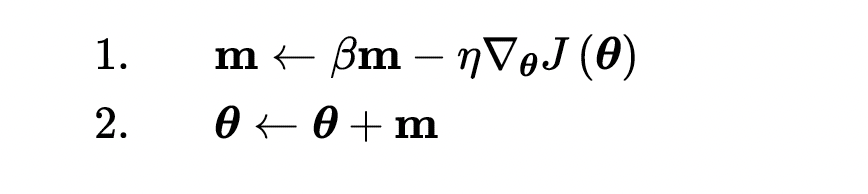

In [ ]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])



In [ ]:
def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

Momentum

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6846 - accuracy: 0.7647 - val_loss: 0.5050 - val_accuracy: 0.8166
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4677 - accuracy: 0.8354 - val_loss: 0.4413 - val_accuracy: 0.8384
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4232 - accuracy: 0.8514 - val_loss: 0.4223 - val_accuracy: 0.8488
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3942 - accuracy: 0.8616 - val_loss: 0.3790 - val_accuracy: 0.8608
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3730 - accuracy: 0.8675 - val_loss: 0.3633 - val_accuracy: 0.8706
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3596 - accuracy: 0.8719 - val_loss: 0.3623 - val_accuracy: 0.8692
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3437 - accuracy: 0.8756 - val_loss: 0.3602 - val_accuracy:

In [ ]:
history_momentum = history_sgd

El valor de momentum de 0.9 normalmente
funciona bien en la práctica y casi siempre es más rápido que el gradiente descendiente normal.

**Nesterov Accelerated Gradient (NAG)**

Mide el gradiente de la función de costo no en
la posición local θ pero ligeramente por delante, en la dirección del momentum, en θ + βm. Este pequeño ajuste funciona porque, en general, el vector de momentum
apunta en la dirección correcta (es decir, hacia el óptimo), por lo que será ligeramente más preciso que usar el gradiente medido en la posición original.

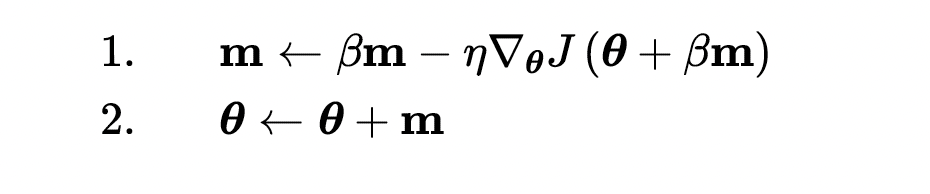

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [ ]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6992 - accuracy: 0.7659 - val_loss: 0.4902 - val_accuracy: 0.8288
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4603 - accuracy: 0.8400 - val_loss: 0.4280 - val_accuracy: 0.8448
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4173 - accuracy: 0.8534 - val_loss: 0.4028 - val_accuracy: 0.8574
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3925 - accuracy: 0.8609 - val_loss: 0.3774 - val_accuracy: 0.8640
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3718 - accuracy: 0.8677 - val_loss: 0.3696 - val_accuracy: 0.8650
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3576 - accuracy: 0.8715 - val_loss: 0.3791 - val_accuracy: 0.8666
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3419 - accuracy: 0.8768 - val_loss: 0.3662 - val_accuracy:

**AdaGrad**

- El algoritmo de gradiente comienza bajando rápidamente por la pendiente más pronunciada, que no apunta directamente hacia el óptimo global, luego muy lentamente desciende hasta el fondo del valle.

- Sería bueno si el algoritmo pudiera corregir su dirección antes para apuntar un poco más hacia el óptimo global. El algoritmo AdaGrad logra esta corrección haciendo escala en el vector de gradiente en
dimensiones más empinadas.

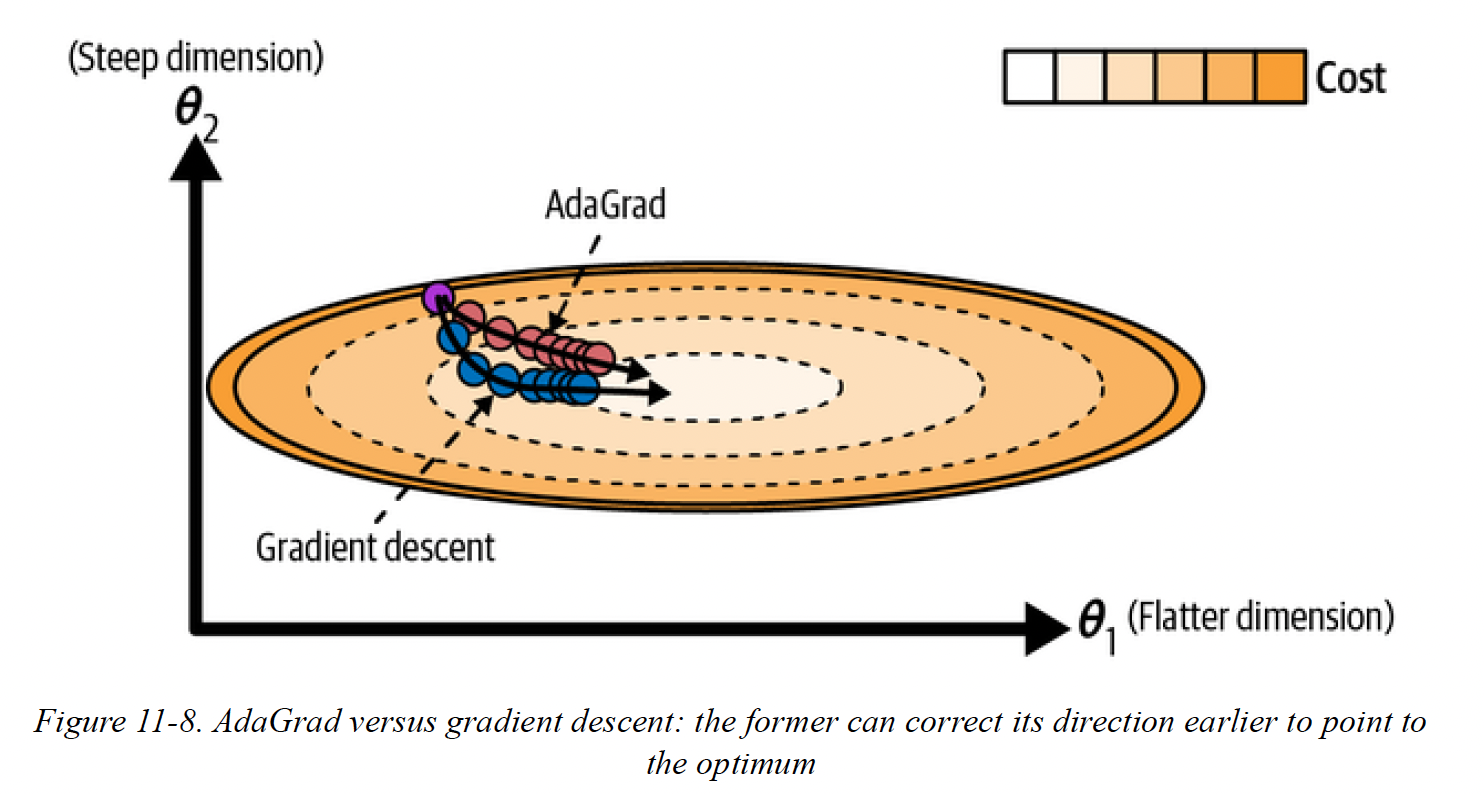

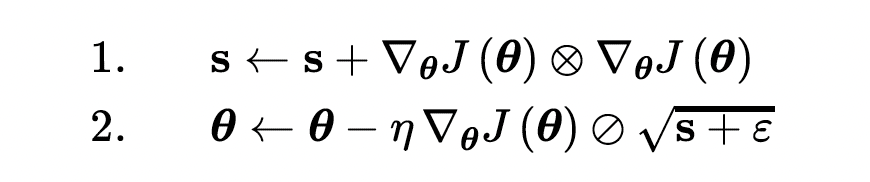

Este algoritmo reduce la tasa de aprendizaje, pero lo hace más rápido para dimensiones empinadas que para dimensiones con pendientes más suaves. Esto se denomina tener una
tasa de aprendizaje adaptativa. Un beneficio adicional es que
requiere mucho menos ajuste del hiperparámetro de tasa de aprendizaje η.

- AdaGrad frecuentemente funciona bien para problemas cuadráticos simples, pero a menudo se detiene demasiado pronto al entrenar redes neuronales: la tasa de aprendizaje aumenta se reduce mucho que el algoritmo termina deteniéndose por completo antes alcanzar el óptimo global.

- No debe usarse para entrenar redes neuronales profundas (puede ser eficiente para tareas más simples como la regresión lineal).

- Comprender AdaGrad es útil para comprender los otros optimizadores adaptativos de tasa de aprendizaje.

In [ ]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [ ]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0126 - accuracy: 0.6627 - val_loss: 0.6913 - val_accuracy: 0.7658
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.6447 - accuracy: 0.7823 - val_loss: 0.5867 - val_accuracy: 0.8010
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5740 - accuracy: 0.8067 - val_loss: 0.5419 - val_accuracy: 0.8162
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5377 - accuracy: 0.8184 - val_loss: 0.5166 - val_accuracy: 0.8198
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5143 - accuracy: 0.8266 - val_loss: 0.4975 - val_accuracy: 0.8260
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4971 - accuracy: 0.8310 - val_loss: 0.4861 - val_accuracy: 0.8298
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4840 - accuracy: 0.8356 - val_loss: 0.4745 - val_accuracy:

**RMSProp**

AdaGrad corre el riesgo de disminuir demasiado rápido y
nunca converge al óptimo global. El algoritmo RMSProp soluciona esto acumulando solo los gradientes de las iteraciones más recientes. Para esto usa un decaimiento exponencial en el primer paso:

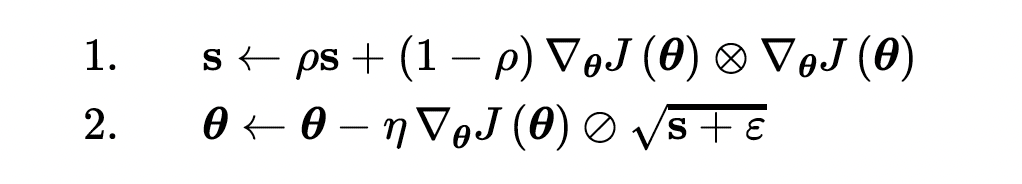

La tasa de decaimiento (decay rate) ρ normalmente se establece en 0.9, este valor predeterminado a menudo funciona bien, sin necesidad de afinarlo.

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [ ]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5084 - accuracy: 0.8171 - val_loss: 0.4408 - val_accuracy: 0.8336
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3885 - accuracy: 0.8595 - val_loss: 0.4078 - val_accuracy: 0.8474
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3616 - accuracy: 0.8717 - val_loss: 0.4004 - val_accuracy: 0.8654
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3554 - accuracy: 0.8762 - val_loss: 0.3722 - val_accuracy: 0.8714
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3472 - accuracy: 0.8789 - val_loss: 0.3713 - val_accuracy: 0.8704
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3471 - accuracy: 0.8799 - val_loss: 0.4622 - val_accuracy: 0.8546
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3497 - accuracy: 0.8793 - val_loss: 0.4783 - val_accuracy:

Excepto en problemas muy simples, este optimizador casi siempre es mejor que AdaGrad. De hecho, fue la optimización preferida  de muchos investigadores hasta que llegó la optimización de Adam.

**Adam Optimization**

Adam combina las ideas de optimización del momentum y RMSProp:
- Al igual que la optimización de momentum mantiene el promedio del decaimiento exponencial de las gradientes anteriores;
- Al igual que RMSProp, mantiene el promedio de un exponencial decreciente de gradientes cuadráticos anteriores.
- Estas son estimaciones de la media y la varianza (no centrada) de las gradientes.
- El promedios se denomina primer momento, mientras que la varianza a menudo se denomina segundo momento.

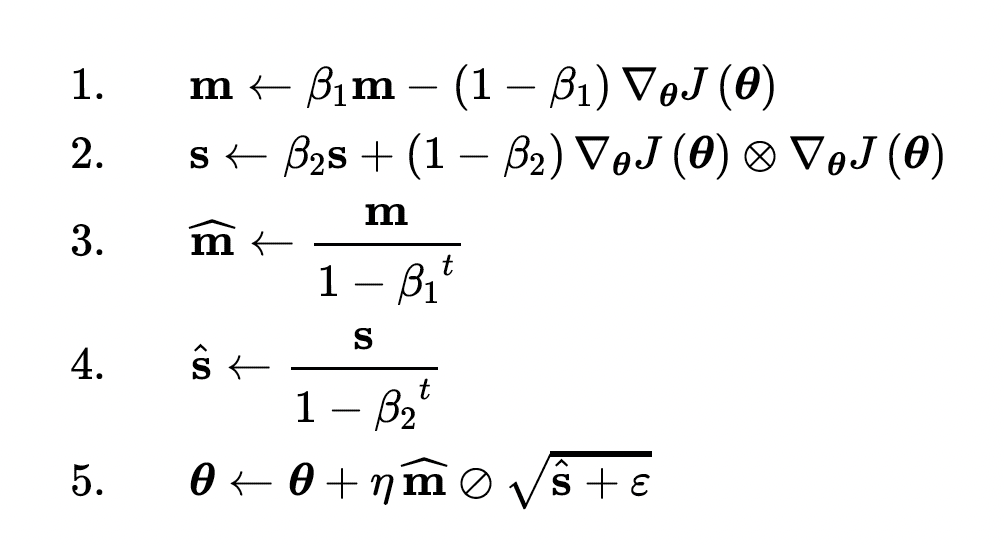

Si se observa los pasos 1, 2 y 5, notará la similitud de Adam
tanto para la optimización del momentum como para RMSProp:
- $β_1$ corresponde a β en optimización del momentum, y
- $β_2$ corresponde a ρ en RMSProp.

El hiperparámetro de caída de momento $\beta_1$ normalmente se inicializa en 0.9, mientras que el hiperparámetro de caída de la escala $\beta_2$  se inicializa en 0.999.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [ ]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.5004 - accuracy: 0.8193 - val_loss: 0.4149 - val_accuracy: 0.8386
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3751 - accuracy: 0.8626 - val_loss: 0.3976 - val_accuracy: 0.8424
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3404 - accuracy: 0.8758 - val_loss: 0.3459 - val_accuracy: 0.8744
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3177 - accuracy: 0.8824 - val_loss: 0.3537 - val_accuracy: 0.8754
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2984 - accuracy: 0.8887 - val_loss: 0.3293 - val_accuracy: 0.8772
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2845 - accuracy: 0.8937 - val_loss: 0.3453 - val_accuracy: 0.8744
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2718 - accuracy: 0.8974 - val_loss: 0.3268 - val_accuracy:

Dado que Adam es un algoritmo de tasa de aprendizaje adaptativo, como AdaGrad y RMSProp, requiere menos ajuste del hiperparámetro de tasa de aprendizaje η.

A menudo se puede usar el valor predeterminado η = 0.001, lo que hace que Adam sea más fácil de usar que gradiente descendiente.

**Adamax Optimization**

AdamMax es más estable que Adam, pero realmente depende del conjunto de datos y, en general, Adam tiene desempeño mejor.

In [ ]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [ ]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5382 - accuracy: 0.8120 - val_loss: 0.4413 - val_accuracy: 0.8380
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4013 - accuracy: 0.8567 - val_loss: 0.4043 - val_accuracy: 0.8516
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3625 - accuracy: 0.8684 - val_loss: 0.3840 - val_accuracy: 0.8620
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3374 - accuracy: 0.8771 - val_loss: 0.3548 - val_accuracy: 0.8724
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3173 - accuracy: 0.8849 - val_loss: 0.3276 - val_accuracy: 0.8742
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3023 - accuracy: 0.8890 - val_loss: 0.3454 - val_accuracy: 0.8748
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2882 - accuracy: 0.8934 - val_loss: 0.3378 - val_accuracy:

**Nadam Optimization**

La optimización de Nadam es la optimización de Adam más la adición  de Nesterov, por lo que debería tener una convergencia un poco más rápida que Adam.

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [ ]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4846 - accuracy: 0.8277 - val_loss: 0.4024 - val_accuracy: 0.8504
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3647 - accuracy: 0.8675 - val_loss: 0.3668 - val_accuracy: 0.8626
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3325 - accuracy: 0.8773 - val_loss: 0.3632 - val_accuracy: 0.8730
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3116 - accuracy: 0.8858 - val_loss: 0.3284 - val_accuracy: 0.8766
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2947 - accuracy: 0.8904 - val_loss: 0.3384 - val_accuracy: 0.8738
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2810 - accuracy: 0.8946 - val_loss: 0.3353 - val_accuracy: 0.8828
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2693 - accuracy: 0.8991 - val_loss: 0.3574 - val_accu

**AdamW Optimization**



AdamW es una variante de Adam que integra una técnica de regularización llamada weight decay. Esto reduce el tamaño de los pesos del modelo en cada iteración de entrenamiento al  multiplicándolos por un factor de caída, por ejemplo 0.99.

In [ ]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [ ]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4998 - accuracy: 0.8224 - val_loss: 0.4151 - val_accuracy: 0.8340
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3729 - accuracy: 0.8649 - val_loss: 0.3933 - val_accuracy: 0.8560
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3388 - accuracy: 0.8760 - val_loss: 0.3675 - val_accuracy: 0.8680
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3158 - accuracy: 0.8843 - val_loss: 0.3379 - val_accuracy: 0.8800
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2978 - accuracy: 0.8890 - val_loss: 0.3247 - val_accuracy: 0.8770
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2818 - accuracy: 0.8947 - val_loss: 0.3411 - val_accuracy: 0.8784
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2737 - accuracy: 0.8961 - val_loss: 0.3543 - val_accuracy:

**Curvas de Aprendizaje de todos los optimizadores**

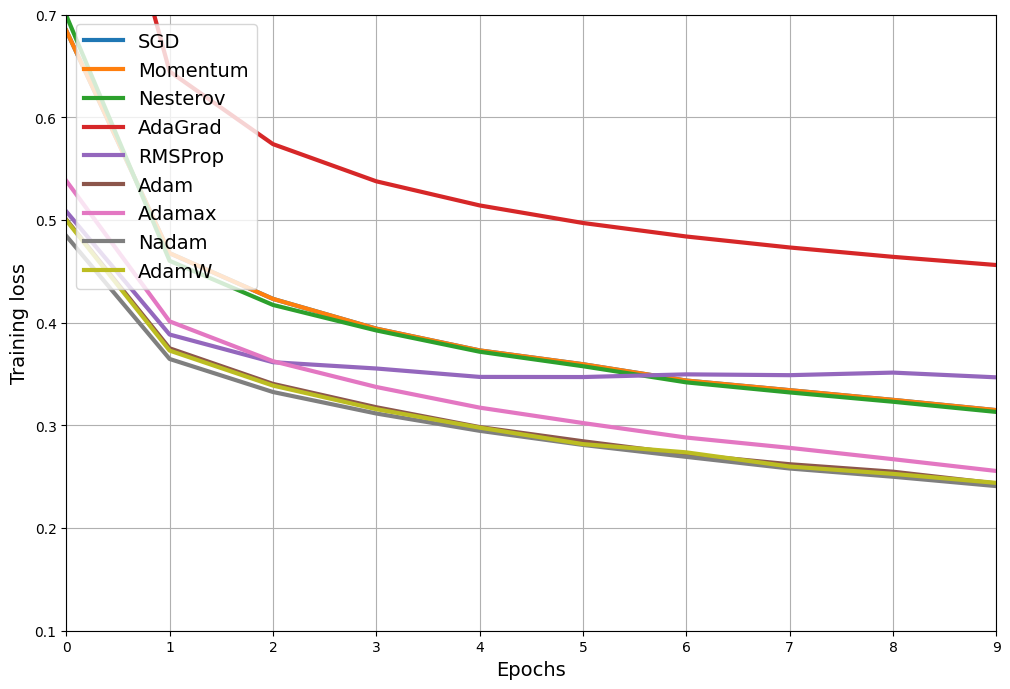

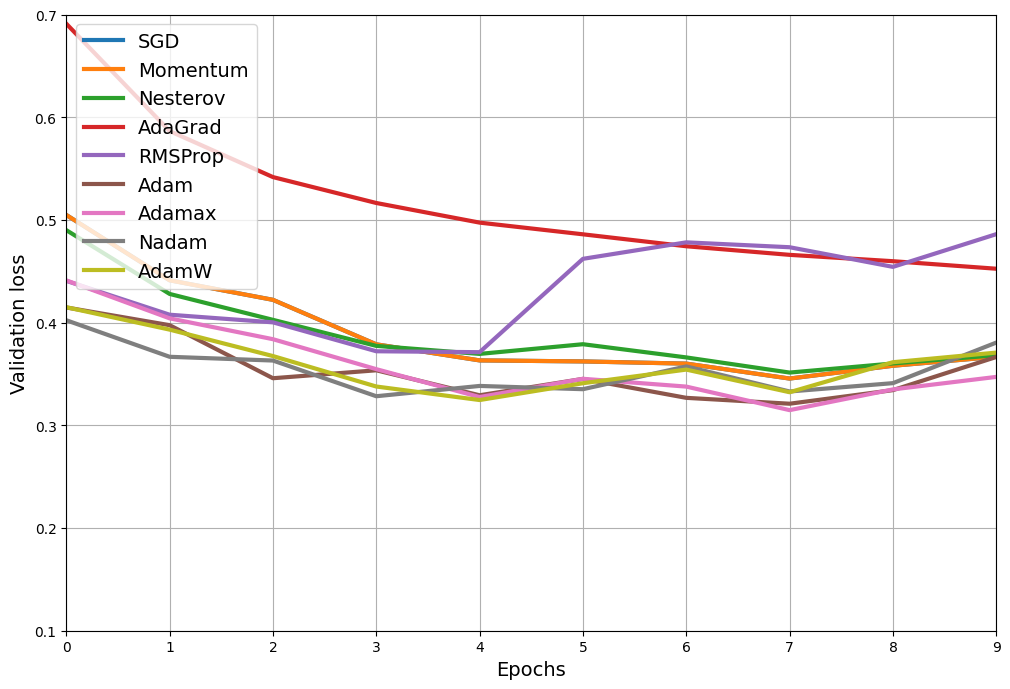

In [ ]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

**Comparación**

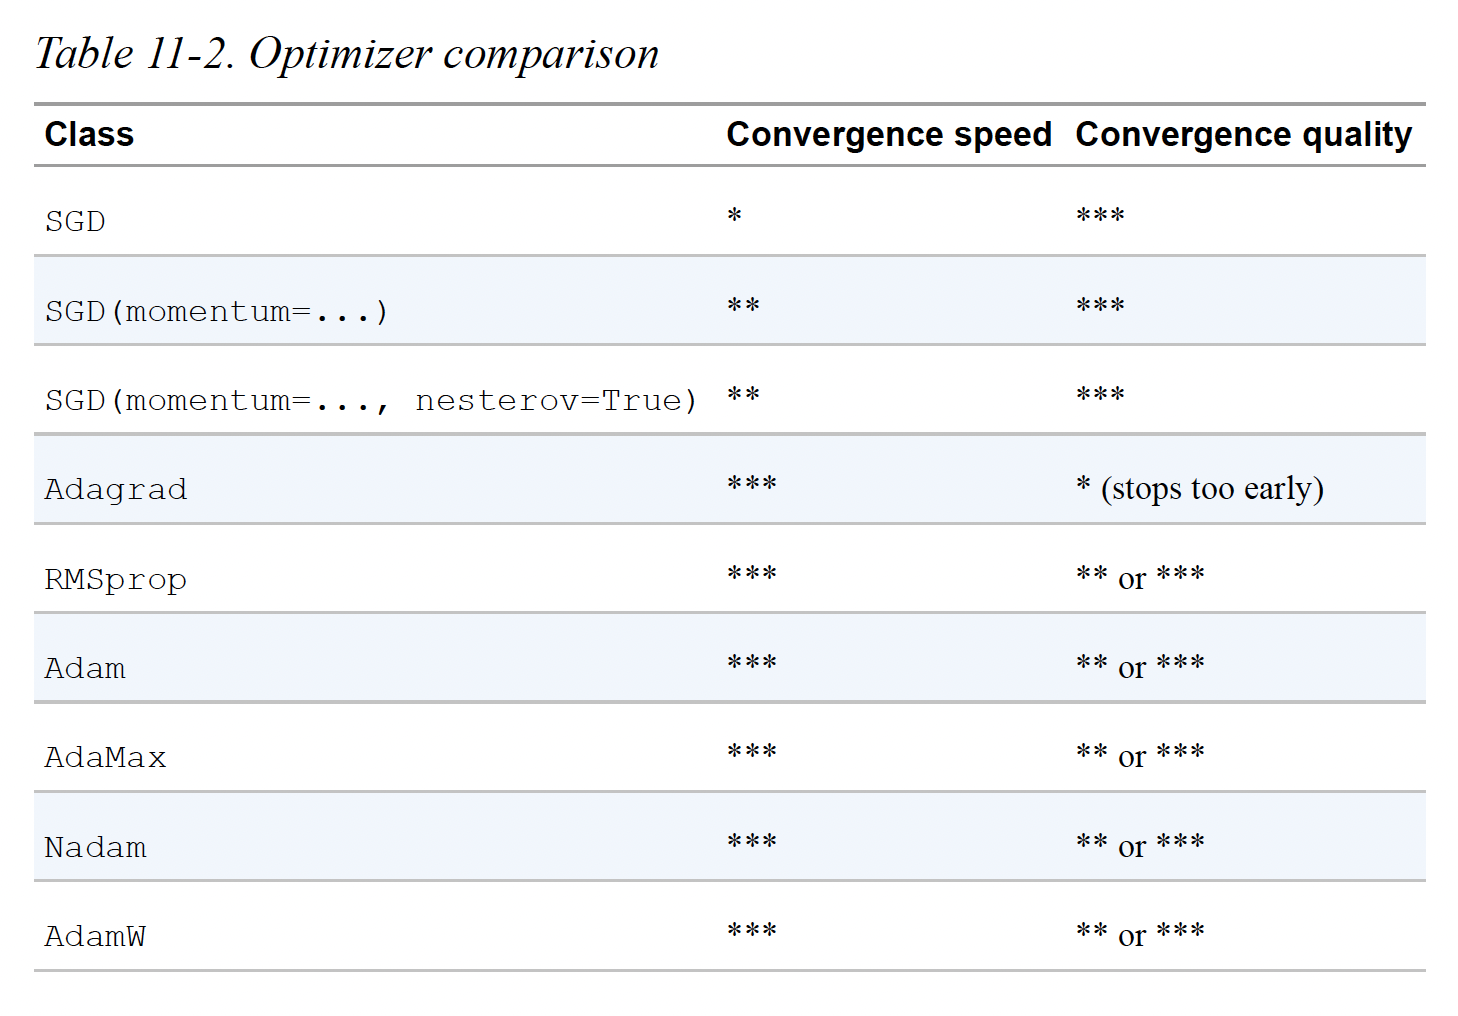


Nota: métodos de optimización adaptativa (incluidos RMSProp, Adam, Adamax, Nadam y
optimización AdamW) suelen ser excelentes y convergen rápidamente hacia una buena solución. Sin embargo, shia C. Wilson et al. (2017) demostraron que no generalizan bien en algunos conjuntos de datos.

Entonces, cuando el desempeño de tu modelo no sea óptimo, intente usar NAG: el conjunto de datos puede simplemente ser alérgico a gradientes adaptativos.

##**Learning Rate Scheduling**


- Encontrar una buena tasa de aprendizaje es muy importante. Si es muy grande, el entrenamiento puede divergir.
- Si es muy baja, el entrenamiento eventualmente convergirá al óptimo, pero tomará mucho tiempo.
-  Si se tiene un presupuesto limitado, es posible que tenga que
interrumpir el entrenamiento antes de que haya convergido adecuadamente, lo que produce un resultado subóptimo.


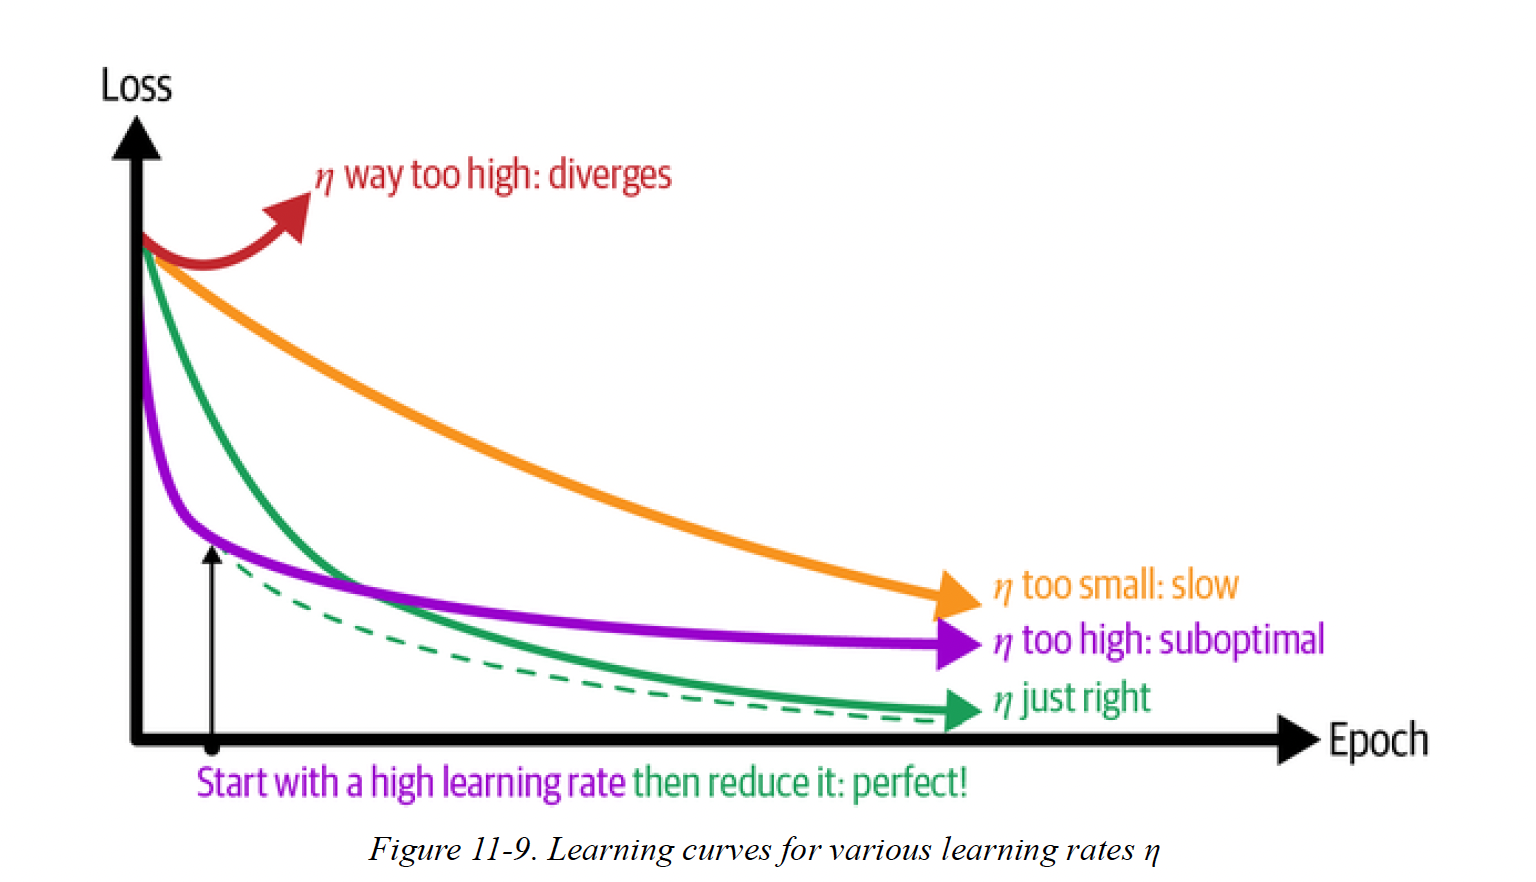

**Alternativa estática**

- Se puede encontrar una buena tasa de aprendizaje entrenando
el modelo durante unos cientos de iteraciones, aumentando exponencialmente la tasa de aprendizaje de un valor muy pequeño a un valor muy grande, y luego mirando la curva de aprendizaje y eligiendo una tasa de aprendizaje ligeramente inferior al momento en el que la curva de aprendizaje comienza a dispararse.

- Entonces, se puede Reinicializar el modelo y entrenarlo con esa tasa de aprendizaje.


Esto es una tasa de aprendizaje constante, pero se podría hacer mejor:

- Si se comienza con una gran tasa de aprendizaje y luego se reduce cuando el entrenamiento deja de progresar rápidamente. De esta forma se puede llegar a una buena solución más rápido que con el aprendizaje constante.

Existen muchas estrategias diferentes para reducir la tasa de aprendizaje durante el entrenamiento estas son las  *Learning schedules*.



**Power Scheduling**


Establezca la tasa de aprendizaje en función del número de iteraciones t: $η(t) = η_0 / (1 + t/s)^c$ .

La tasa de aprendizaje inicial η, la potencia c (normalmente en 1) y los pasos s. La tasa de aprendizaje cae en cada paso.

- Después de s pasos, la tasa de aprendizaje se reduce a $η_0 / 2$. Después de s pasos más, está en $η_0/3$, luego baja a $η_0/4$, luego $η_0/5$, y así sucesivamente.
- Este schedule primero disminuye rápidamente y luego cada vez más lentamente.

- Por supuesto, power scheduling requiere afinar $η_0$ y s (y posiblemente c).



learning_rate = initial_learning_rate / (1 + step / decay_steps)**power

Keras uses power = 1.



El argumento de decay-steps en los optimizadores está en desuso. Los optimizadores antiguos que implementan este argumento todavía están disponibles en tf.keras.optimizers.legacy, pero en su lugar se debería usar tf.keras.optimizers.schedules.

In [ ]:
# DEPRECATED:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [ ]:
# RECOMMENDED:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6775 - accuracy: 0.7686 - val_loss: 0.4773 - val_accuracy: 0.8302
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4693 - accuracy: 0.8351 - val_loss: 0.4597 - val_accuracy: 0.8324
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4241 - accuracy: 0.8488 - val_loss: 0.4181 - val_accuracy: 0.8540
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4011 - accuracy: 0.8595 - val_loss: 0.3911 - val_accuracy: 0.8628
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3823 - accuracy: 0.8648 - val_loss: 0.3883 - val_accuracy: 0.8620
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3687 - accuracy: 0.8688 - val_loss: 0.3893 - val_accuracy: 0.8602
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3591 - accuracy: 0.8719 - val_loss: 0.3734 - val_accuracy:

InverseTimeDecay usa learning_rate = inicial_learning_rate / (1 + decay_rate * step / decay_steps).

Si staircase = True, se cambia ``step / decay_step`` con ``floor(step / decay_step)``


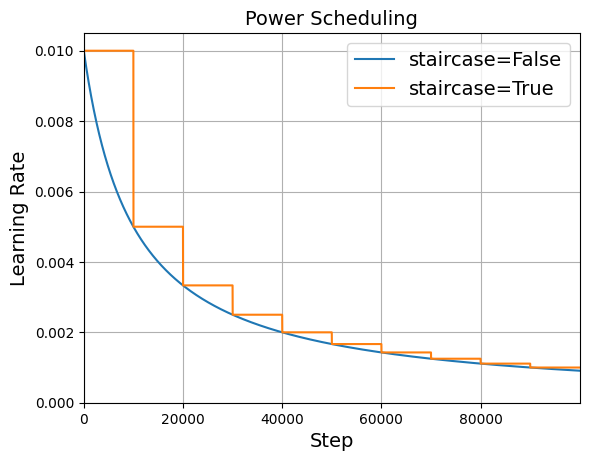

In [ ]:
# extra code – this cell plots power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

**Exponential scheduling**

- Se define la tasa de aprendizaje en $η(t) = η_0 0.1^{t/s}$.

- La tasa de aprendizaje gradualmente caerá por un factor de 10 a cada s pasos. Mientras que power scheduling reduce la tasa de aprendizaje cada vez más lento, Exponential scheduling sigue disminuyendo por un factor de 10 a cada s pasos.

learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6859 - accuracy: 0.7661 - val_loss: 0.4910 - val_accuracy: 0.8240
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4727 - accuracy: 0.8340 - val_loss: 0.4487 - val_accuracy: 0.8380
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4267 - accuracy: 0.8487 - val_loss: 0.4165 - val_accuracy: 0.8500
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4032 - accuracy: 0.8585 - val_loss: 0.3953 - val_accuracy: 0.8576
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3856 - accuracy: 0.8643 - val_loss: 0.3872 - val_accuracy: 0.8590
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3728 - accuracy: 0.8683 - val_loss: 0.3880 - val_accuracy: 0.8612
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3642 - accuracy: 0.8710 - val_loss: 0.3758 - val_accuracy:

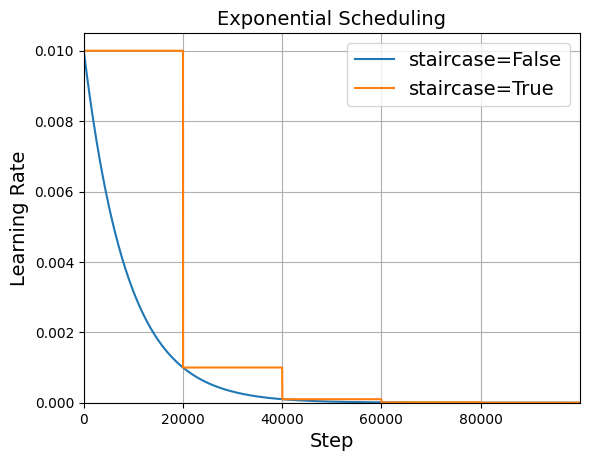

In [ ]:
# extra code – this cell plots exponential scheduling

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

**Piecewise Constant Scheduling**


- Utilice una tasa de aprendizaje constante para varias épocas (por ejemplo, η = 0.1 para 5 épocas)

- Luego una tasa de aprendizaje menor para otro número de épocas (por ejemplo, η = 0.001 para 50 épocas), y así sucesivamente.

- Aunque esta solución puede funcionar muy bien, requiere tiempo para descubrir la secuencia correcta de tasas de aprendizaje.

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6868 - accuracy: 0.7676 - val_loss: 0.4863 - val_accuracy: 0.8292
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4656 - accuracy: 0.8362 - val_loss: 0.4521 - val_accuracy: 0.8384
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4179 - accuracy: 0.8516 - val_loss: 0.4118 - val_accuracy: 0.8546
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3931 - accuracy: 0.8604 - val_loss: 0.3879 - val_accuracy: 0.8624
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3719 - accuracy: 0.8677 - val_loss: 0.3744 - val_accuracy: 0.8668
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3548 - accuracy: 0.8733 - val_loss: 0.3931 - val_accuracy: 0.8598
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3430 - accuracy: 0.8761 - val_loss: 0.3677 - val_accuracy:

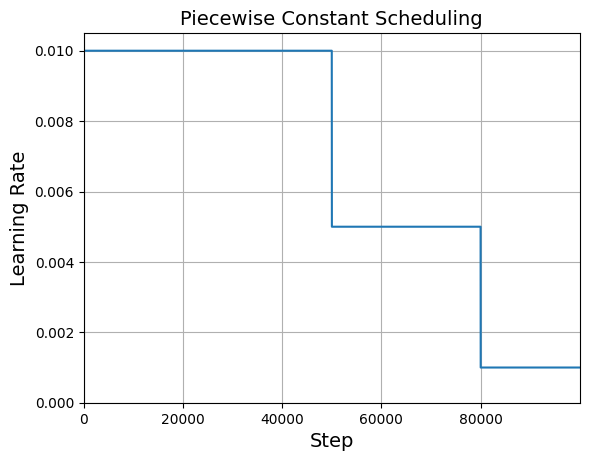

In [ ]:
# extra code – this cell plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**Performance scheduling**

Mide el error de validación cada N pasos (al igual que para early stopping), y reduce la tasa de aprendizaje en un factor de λ cuando el error para.

In [ ]:
lr0 = 0.01
n_epochs = 25

In [ ]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6862 - accuracy: 0.7650 - val_loss: 0.4765 - val_accuracy: 0.8250 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4666 - accuracy: 0.8356 - val_loss: 0.4399 - val_accuracy: 0.8416 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4182 - accuracy: 0.8511 - val_loss: 0.4136 - val_accuracy: 0.8572 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3937 - accuracy: 0.8602 - val_loss: 0.3793 - val_accuracy: 0.8644 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3722 - accuracy: 0.8676 - val_loss: 0.3696 - val_accuracy: 0.8690 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3561 - accuracy: 0.8724 - val_loss: 0.3793 - val_accuracy: 0.8666 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 7s

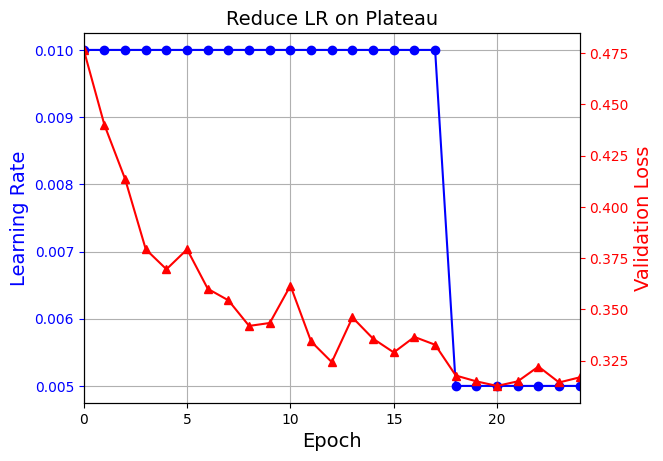

In [ ]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

**1cycle scheduling**

- 1cycle (Smith, 2018) inicia aumentando la tasa de aprendizaje  $η_0$, linealmente hasta llegar a $η_1$ a mitad del entrenamiento.
- Luego disminuye la tasa de aprendizaje linealmente hasta llegar a $η_0$, durante la segunda mitad del entrenando. Finaliza las últimas épocas disminuyendo la tasa, en varios órdenes de magnitud (aún linealmente).
- La tasa máxima de aprendizaje $η_1$ se elige usando el mismo enfoque que se usa para encontrar la tasa de aprendizaje óptima de forma estática.
- La tasa de aprendizaje inicial $η_0$ suele ser 10 veces menor.
- Si se usa momentum se hace un proceso similar.

Smith hizo muchos experimentos que demostraron que este enfoque a menudo podía acelerar el entrenamiento considerablemente y alcanzar un mejor rendimiento.

Por ejemplo, sobre CIFAR10, este enfoque alcanzó el 91,9% de accuracy en validación en solo 100 épocas, en comparación al 90,3% obtenido en 800 épocas usando un enfoque estándar. Esta hazaña se denominó superconvergencia.

he ExponentialLearningRate custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant factor. It also saves the learning rate and loss at each batch. Since logs["loss"] is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [ ]:
import math

Esta clase actualiza la taza de aprendizaje durante el entrenamiento, al finalizar cada batch.

In [ ]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

La función find_learning_rate() entrena el modelo usando el callback ExponentialLearningRate y retorna las tasas de aprendizaje y sus correspondientes losses. Al finalizar restaura el modelo y optimizador a su estado inicial.

In [ ]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

La función plot_lr_vs_loss() grafica los learning rates vs los losses. La taza de aprendizaje óptima para utilizar como valor máximo en 1cycle está cerca la parte inferior de la curva.

In [ ]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Se construye un modelo para Fashion MNIST y se compila:

In [ ]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Se encuentra la taza de aprendizaje máxima para 1cycle:

430/430 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.3961


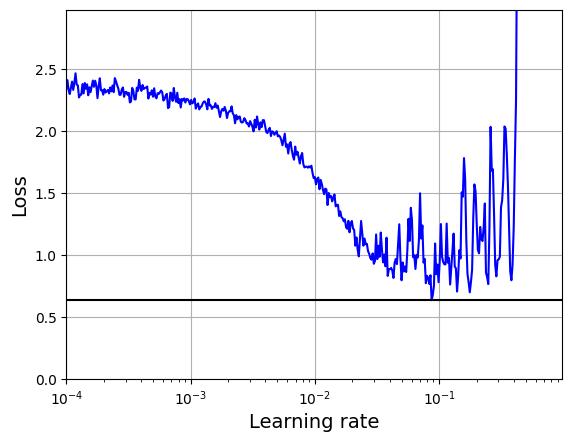

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

La taza de aprendizaje máxima para usar en 1cycle es cerca a $10^{-1}$.

The OneCycleScheduler custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

La clase OneCycleScheduler callback actualiza la tasa de aprendizaje al inicio de cada batch. Aplica la lógica 1cycle: aumenta la tasa de aprendizaje linealmente durante aproximadamente la mitad del entrenamiento, luego reduce linealmente hasta la tasa de aprendizaje inicial y, por último, la reduce linealmente hasta cerca de cero durante la última parte del entrenamiento.

In [ ]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Uso de OneCycleScheduler callback:

In [ ]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 4s 6ms/step - loss: 0.9923 - accuracy: 0.6731 - val_loss: 0.6041 - val_accuracy: 0.7972
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.5788 - accuracy: 0.7961 - val_loss: 0.4942 - val_accuracy: 0.8274
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.5044 - accuracy: 0.8216 - val_loss: 0.4528 - val_accuracy: 0.8398
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4553 - accuracy: 0.8388 - val_loss: 0.4282 - val_accuracy: 0.8456
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.4255 - accuracy: 0.8491 - val_loss: 0.4416 - val_accuracy: 0.8294
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3974 - accuracy: 0.8572 - val_loss: 0.5768 - val_accuracy: 0.7918
Epoch 7/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3827 - accuracy: 0.8617 - val_loss: 0.3907 - val_accuracy: 0.8562
Epoch 

##**Regularización: Overfitting**

**Regularización $\mathcal{l}_1$ y $\mathcal{l}_2$**

Se puede usar regularización $ℓ_2$ para disminuir los pesos de la red neuronla y regularización $ℓ_1$ si se desea un modelo sparse (con muchos pesos iguales 0). Vea un ejempplo para $l_2$:

In [ ]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

In [ ]:
tf.random.set_seed(42)

La función a seguir permite crear un wrapper llamada de capas, con algunos valores de argumentos por default (para evitar repeticiones de código)

In [ ]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [ ]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.1313 - accuracy: 0.7736 - val_loss: 1.8626 - val_accuracy: 0.8222
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.4287 - accuracy: 0.8136 - val_loss: 1.1307 - val_accuracy: 0.8160


**Dropout**


- Técnica de regularización más popular para edes neuronales Profundas (Hinton et al., 2012; Nitish Srivastava et al. 2014). Trae mejoras significativas

- Es un algoritmo bastante simple: en cada paso del entrenamiento, cada neurona (incluidas las neuronas de entrada, y exceptuando las las neuronas de salida) tiene una probabilidad p de ser "borradas" temporalmente, lo que significa que será ignorada por completo durante este paso de entrenamiento, pero puede estar activa durante el
siguiente paso.

- El hiperparámetro p se llama tasa de dropout y normalmente se establece entre el 10% y el 50%:
 - más cerca del 20% al 30% en redes neuronales recurrentes ,
 - más cerca del 40% -50% en redes neuronales convolucionales.

- Después del entrenamiento no se apagan o borran más.

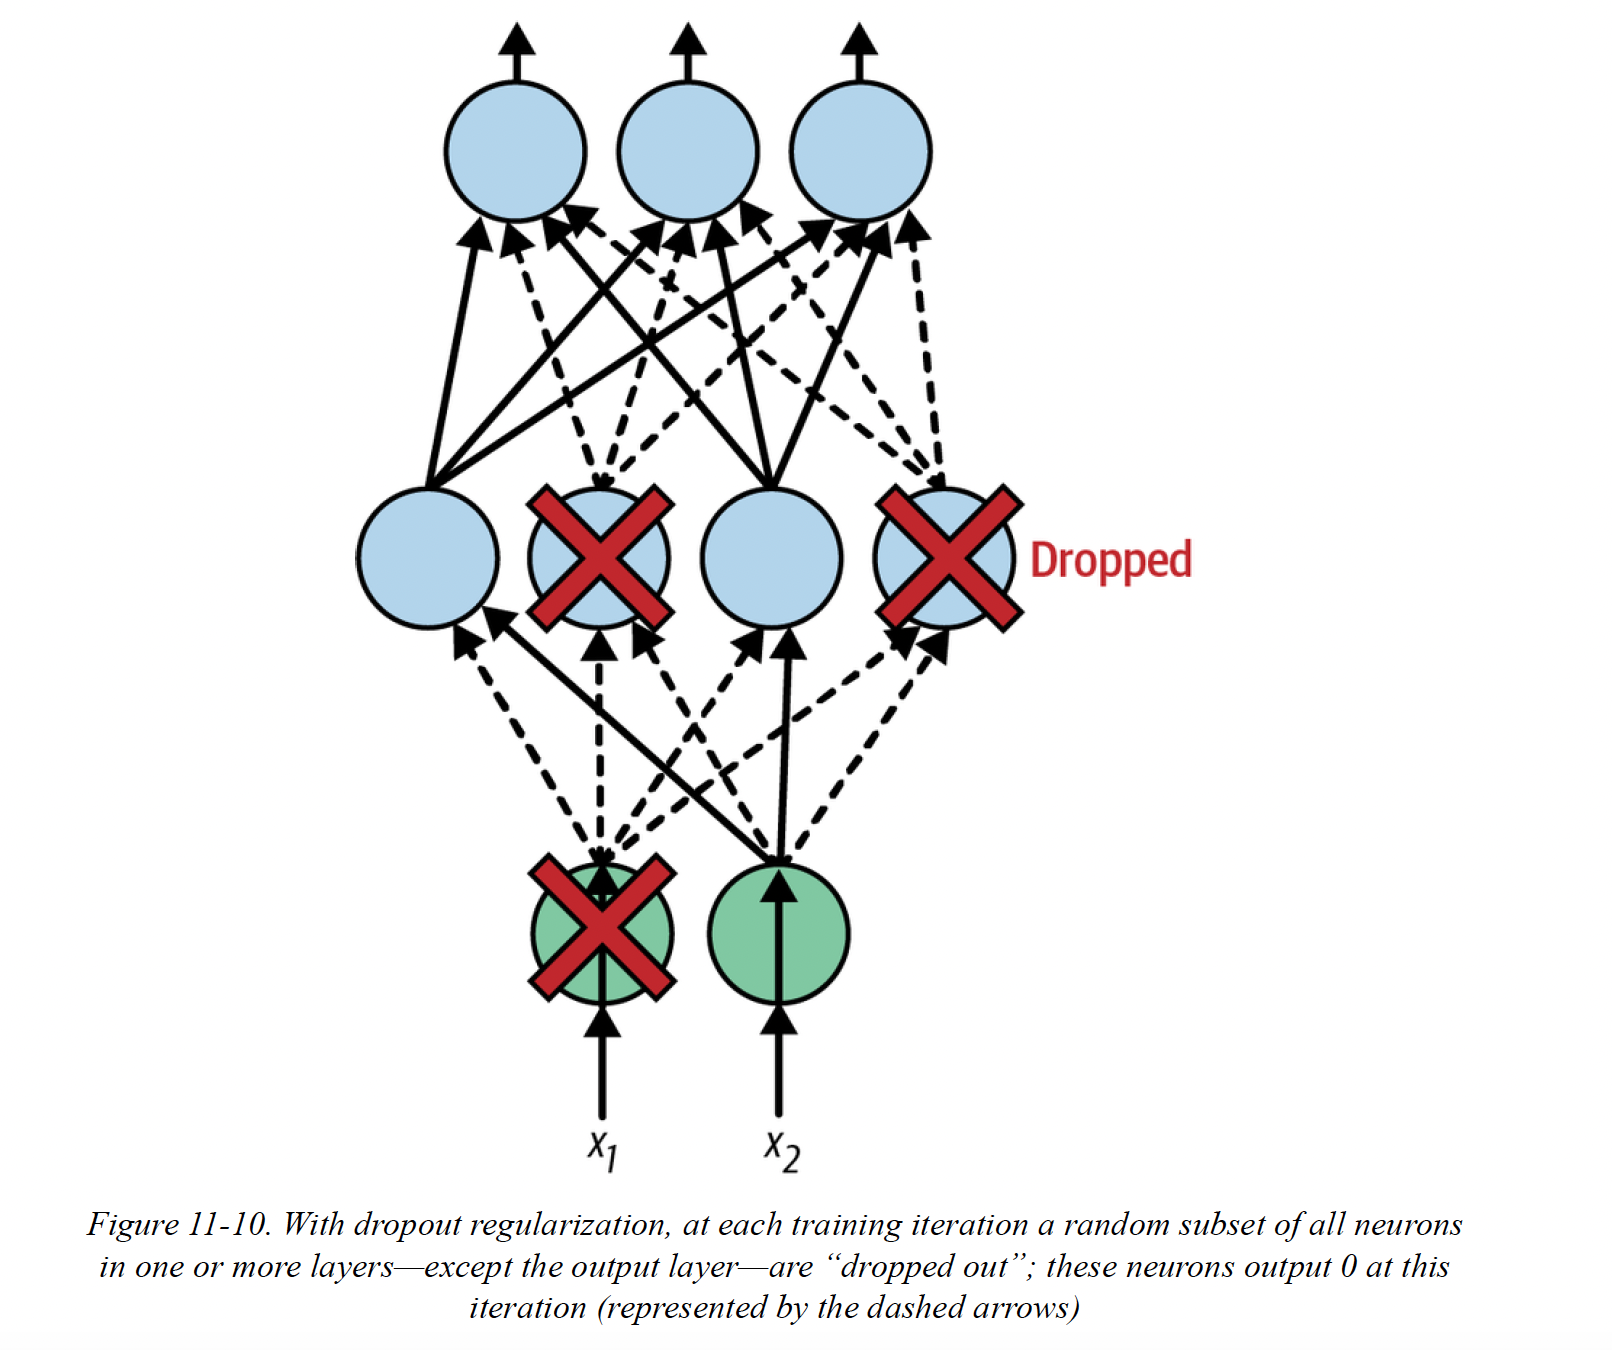

**Nota:** Dado que el abandono sólo está activo durante el entrenamiento, comparar el loss de entrenamiento y
validación puede ser engañoso. Por lo tanto, asegúrese de evaluar el loss del entrenamiento sin droput (por ejemplo, al finalizar el proceso de entrenamiento).

Reglas:

- Si observa que el modelo tiene overfitting, puede aumentar el dropout.
- Por el contrario, debería intentar disminuir la tasa de abandono si hay underfit.
- Las arquitecturas actuales solo usan droput después de la última capa oculta.
- El droput tiende a ralentizar significativamente la convergencia, pero a menudo da como resultado un mejor modelo cuando se ajusta correctamente.
- Por lo tanto, en general vale la pena el tiempo y el esfuerzo extra, especialmente para modelos grandes.

In [ ]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6735 - accuracy: 0.7525 - val_loss: 0.4635 - val_accuracy: 0.8176
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5079 - accuracy: 0.8144 - val_loss: 0.4145 - val_accuracy: 0.8454
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4755 - accuracy: 0.8253 - val_loss: 0.3933 - val_accuracy: 0.8544
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4511 - accuracy: 0.8342 - val_loss: 0.3882 - val_accuracy: 0.8590
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4336 - accuracy: 0.8388 - val_loss: 0.3668 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4253 - accuracy: 0.8431 - val_loss: 0.3696 - val_accuracy: 0.8674
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4119 - accuracy: 0.8492 - val_loss: 0.3662 - val_accura




El accuracy del entrenamiento parece ser menor que el de validación, pero eso se debe simplemente a que Dropout está activo durante el entrenamiento.

Si se evalua el modelo en el conjunto de entrenamiento después del entrenamiento (con droput desactivado), se obtiene el accuracy  del entrenamiento "real", que es ligeramente mayor que el de validación y prueba:

In [ ]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3062 - accuracy: 0.8854


[0.30622798204421997, 0.885418176651001]

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3649 - accuracy: 0.8672


[0.36489197611808777, 0.8672000169754028]

Nota: asegurarse de usar AlphaDropout en vez de Dropout si se desea construir una red self-normalizing con SELU.

**Investigar MC Droput y Max-Norm regularization**

Resumen:

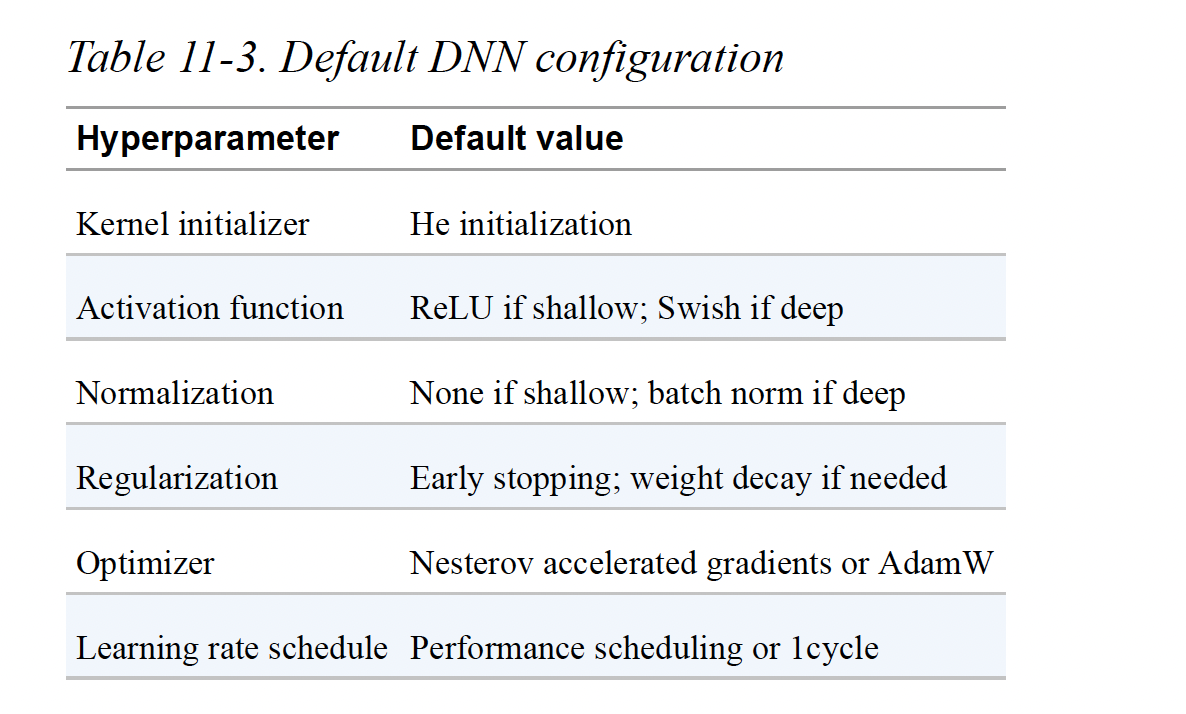

Resumen (Self organizing DNN):

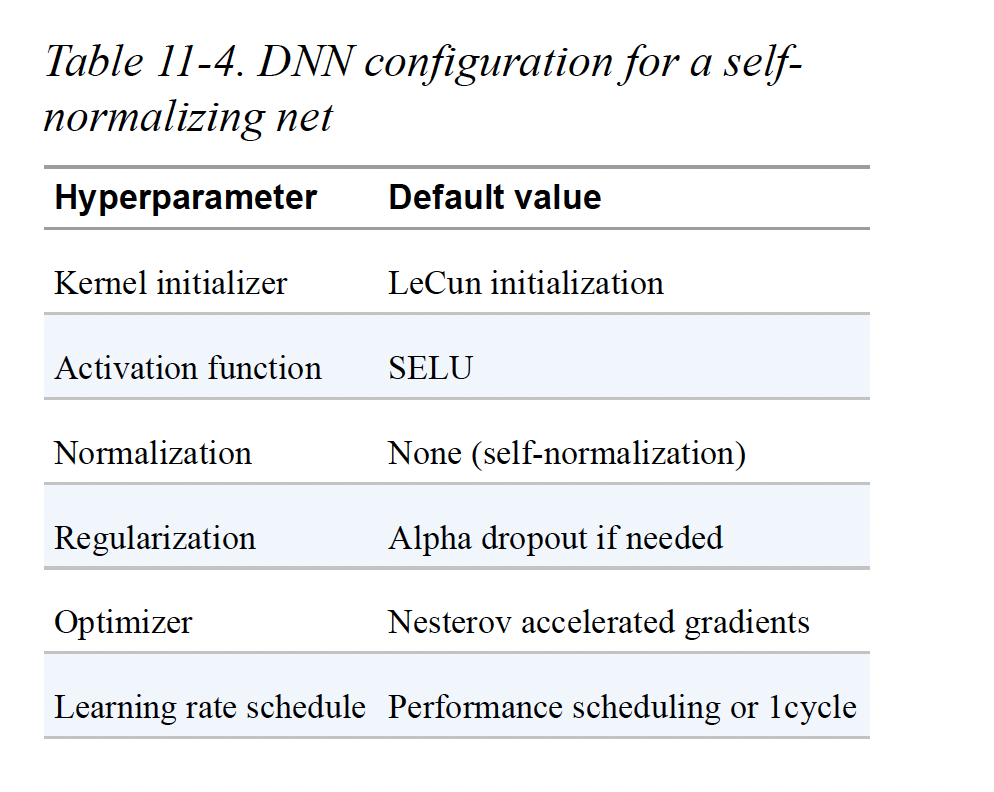
